Demo notebook that showcases training of the PTAViT3D based on the AI4Boundaries dataset ( https://github.com/waldnerf/ai4boundaries/tree/main )    

This code here is not efficient, but simplified for ease of reproducibility. We recommend utilizing the rocksdb dataset class as presented in our SSG2 paper ( https://github.com/feevos/ssg2 ) for efficient I/O. Nevertheless it is possible
to train on a single H100 within a few minutes of training. 

Here we assume that you downloaded the S2 time series of data in some directory and you read iteratively from the hard drive the data. 

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import rasterio, glob, xarray as xr
import os,sys

In [3]:
# Normalization and transform functions

class AI4BNormal_S2(object):
    """
    class for Normalization of images, per channel, in format CHW 
    """
    def __init__(self):

        self._mean_s2 = np.array([5.4418573e+02, 7.6761194e+02, 7.1712860e+02, 2.8561428e+03 ]).astype(np.float32) 
        self._std_s2  = np.array( [3.7141626e+02, 3.8981952e+02, 4.7989127e+02 ,9.5173022e+02]).astype(np.float32) 

    def __call__(self,img):

        temp = img.astype(np.float32)
        temp2 = temp.T
        temp2 -= self._mean_s2
        temp2 /= self._std_s2

        temp = temp2.T
        return temp


    
import albumentations as A
from albumentations.core.transforms_interface import  ImageOnlyTransform
class TrainingTransformS2(object):
    # Built on Albumentations, this provides geometric transformation only  
    def __init__(self,  prob = 1., mode='train', norm = AI4BNormal_S2() ):
        self.geom_trans = A.Compose([
                    A.RandomCrop(width=128, height=128, p=1.0),  # Always apply random crop
                    A.OneOf([
                        A.HorizontalFlip(p=1),
                        A.VerticalFlip(p=1),
                        A.ElasticTransform(p=1), # VERY GOOD - gives perspective projection, really nice and useful - VERY SLOW   
                        A.GridDistortion(distort_limit=0.4,p=1.),
                        A.ShiftScaleRotate(shift_limit=0.25, scale_limit=(0.75,1.25), rotate_limit=180, p=1.0), # Most important Augmentation   
                        ],p=1.)
                    ],
            additional_targets={'imageS1': 'image','mask':'mask'},
            p = prob)
        if mode=='train':
            self.mytransform = self.transform_train
        elif mode =='valid':
            self.mytransform = self.transform_valid
        else:
            raise ValueError('transform mode can only be train or valid')
            
            
        self.norm = norm
        
    def transform_valid(self, data):
        timgS2, tmask = data
        if self.norm is not None:
            timgS2 = self.norm(timgS2)
        
        tmask= tmask 
        return timgS2,  tmask.astype(np.float32)

    def transform_train(self, data):
        timgS2, tmask = data
        
        if self.norm is not None:
            timgS2 = self.norm(timgS2)

        
        tmask= tmask 
        tmask = tmask.astype(np.float32)
        # Special treatment of time series
        c2,t,h,w = timgS2.shape
        #print (c2,t,h,w)              
        timgS2 = timgS2.reshape(c2*t,h,w)
        result = self.geom_trans(image=timgS2.transpose([1,2,0]),
                                 mask=tmask.transpose([1,2,0]))
        timgS2_t = result['image']
        tmask_t  = result['mask']
        timgS2_t = timgS2_t.transpose([2,0,1])
        tmask_t = tmask_t.transpose([2,0,1])
        
        c2t,h2,w2 = timgS2_t.shape

        
        timgS2_t = timgS2_t.reshape(c2,t,h2,w2)
        return timgS2_t,  tmask_t
    def __call__(self, *data):
        return self.mytransform(data)



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import torch
from torch.utils.data import Dataset




class AI4BDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data=r'/path/to/AI4BOUNDARIES/sentinel2/',transform=TrainingTransformS2(), mode='train', ntrain=0.9):
        
        self.flnames_s2_img = sorted(glob.glob(os.path.join(path_to_data,r'images/*/*.nc')))
        self.flnames_s2_mask = sorted(glob.glob(os.path.join(path_to_data,r'masks/*/*.tif')))
        
        assert len(self.flnames_s2_img) == len(self.flnames_s2_mask), ValueError("Some problem, the masks and images are not in the same numbers, aborting")
        
        tlen = len(self.flnames_s2_img)
        
        if mode=='train':
            self.flnames_s2_img = self.flnames_s2_img[:int(ntrain*tlen)]
            self.flnames_s2_mask = self.flnames_s2_mask[:int(ntrain*tlen)]
        elif mode=='valid':
            self.flnames_s2_img = self.flnames_s2_img[int(ntrain*tlen):]
            self.flnames_s2_mask = self.flnames_s2_mask[int(ntrain*tlen):]
        else:
            raise ValueError("Cannot undertand mode::{}, should be either train or valid, aborting...".format(mode))
            
        self.transform=transform                                                              
    # Helper function to read nc to raster 
    def ds2rstr(self,tname):
        variables2use=['B2','B3','B4','B8'] # ,'NDVI']
        ds = xr.open_dataset(tname)
        ds_np = np.concatenate([ds[var].values[None] for var in variables2use],0)

        return ds_np

    def read_mask(self,tname):
        return rasterio.open(tname).read((1,2,3))

    
    def __getitem__(self,idx):
        tname_img = self.flnames_s2_img[idx]
        tname_mask = self.flnames_s2_mask[idx]
        
        timg = self.ds2rstr(tname_img)
        tmask = self.read_mask(tname_mask)
        
        if self.transform is not None:
            timg, tmask = self.transform(timg,tmask)
            
        return timg, tmask
    
    def __len__(self):
        return len(self.flnames_s2_img)

In [5]:
mydataset = AI4BDataset()

In [6]:
timg, tmask = mydataset[10]

# Note we crop the shape to be 128 x 128 for each image, ideally you want to read and save overlapping patches of 128x128 for each 256 training chip. The reason for reduced spatial size stems from the increase in time dimension.

In [7]:
print(timg.shape, tmask.shape)

(4, 6, 128, 128) (3, 128, 128)


In [7]:
from earthpy.plot import plot_rgb

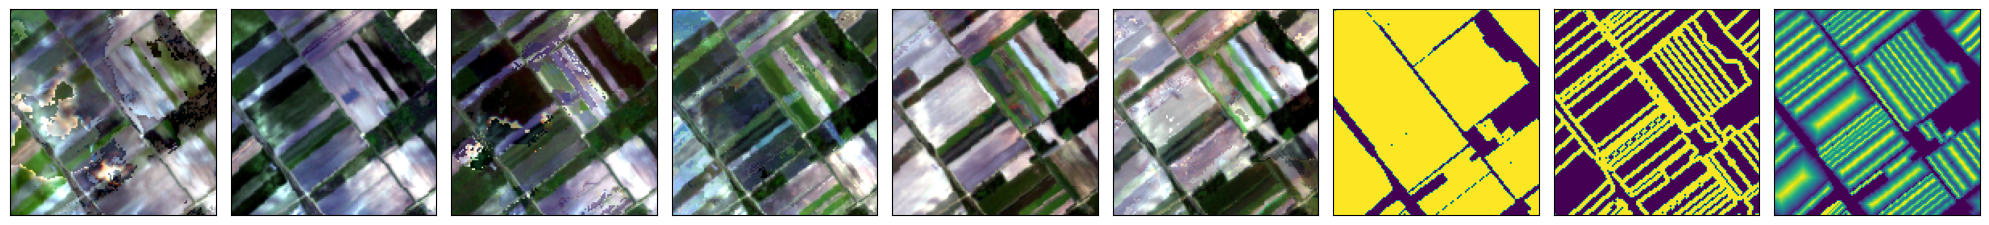

In [9]:
fg, axs = subplots(1,9,figsize=(20,5))



for i in range(6):
    plot_rgb(timg[:,i],ax=axs[i],stretch=True)
for i in range(3):
    axs[6+i].imshow(tmask[i])
    axs[6+i].set_xticks([])
    axs[6+i].set_yticks([])
    
tight_layout()

In [10]:
tmask[1].max()

1.0

# Demo training routine 

In [5]:
sys.path.append(r'/path/to/tfcl_parent')

In [6]:
from torch.utils.data import DataLoader                      
                                                             
from tfcl.models.ptavit3d.ptavit3d_dn import ptavit3d_dn       
from tfcl.nn.loss.ftnmt_loss import ftnmt_loss               
from tfcl.utils.classification_metric import Classification  
from datetime import datetime   


In [7]:
# Set this to False for training
#DEBUG=True
DEBUG=False

In [8]:
def mtsk_loss(preds, labels,criterion, NClasses=1):                   
    # Multitasking loss,    segmentation / boundaries/ distance     
                                                                    
    pred_segm  = preds[:,:NClasses]                                 
    pred_bound = preds[:,NClasses:2*NClasses]                       
    pred_dists = preds[:,2*NClasses:3*NClasses]                     
                                                                    
                                                                    
                                                                    
    # Multitasking loss                                             
    label_segm  = labels[:,:NClasses]                               
    label_bound = labels[:,NClasses:2*NClasses]                     
    label_dists = labels[:,2*NClasses:3*NClasses]                   
                                                                    
                   
    #print(preds.shape, labels.shape)
    
    loss_segm  = criterion(pred_segm,   label_segm)                 
    loss_bound = criterion(pred_bound, label_bound)                 
    loss_dists = criterion(pred_dists, label_dists)                 
                                                                                                                                        
    return (loss_segm+loss_bound+loss_dists)/3.0                    


In [9]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler

def monitor_epoch(model, epoch, datagen_valid, NClasses=1):
    metric_target = Classification(num_classes=NClasses, task='binary').to(1)
    model.eval()

    valid_pbar = tqdm(datagen_valid, desc=f"Validating Epoch {epoch}", position=1, leave=False)
    for idx, data in enumerate(valid_pbar):
        images, labels = data
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        with torch.inference_mode():
            preds_target = model(images)

        pred_segm = preds_target[:, :NClasses]
        label_segm = labels[:, :NClasses]

        metric_target(pred_segm, label_segm)

        if DEBUG and idx > 5:
            break

    metric_kwargs_target = metric_target.compute()

    kwargs = {'epoch': epoch}
    for k, v in metric_kwargs_target.items():
        kwargs[k] = v.cpu().numpy()
    return kwargs


def train(args):
    num_epochs = args.epochs
    batch_size = args.batch_size

    torch.manual_seed(0)
    local_rank = 1
    torch.cuda.set_device(local_rank)

    NClasses = 1
    nf = 96
    verbose = True
    model_config = {'in_channels': 4,
                    'spatial_size_init': (128, 128),
                    'depths': [2, 2, 5, 2],
                    'nfilters_init': nf,
                    'nheads_start': nf // 4,
                    'NClasses': NClasses,
                    'verbose': verbose,
                    'segm_act': 'sigmoid'}

    model = ptavit3d_dn(**model_config).to(local_rank)
    criterion = ftnmt_loss()
    criterion_features = ftnmt_loss(axis=[-3, -2, -1])
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-3, eps=1.e-6)
    scaler = GradScaler()

    train_dataset = AI4BDataset(mode='train')
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=0, pin_memory=True)

    valid_dataset = AI4BDataset(mode='valid')
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=0, pin_memory=True)

    start = datetime.now()
    epoch_pbar = tqdm(range(num_epochs), desc="Epochs", position=0)
    for epoch in epoch_pbar:
        tot_loss = 0
        model.train()
        train_pbar = tqdm(train_loader, desc=f"Training Epoch {epoch}", position=1, leave=False)
        for i, data in enumerate(train_pbar):
            if DEBUG and i > 5:
                break

            images, labels = data
            images = images.to(1, non_blocking=True)
            labels = labels.to(1, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type='cuda', dtype=torch.bfloat16):
                preds_target = model(images)
                loss = mtsk_loss(preds_target, labels, criterion, NClasses)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            tot_loss += loss.item()
            train_pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        kwargs = monitor_epoch(model, epoch, valid_loader, NClasses)
        kwargs['tot_train_loss'] = tot_loss
        if verbose:
            output_str = ', '.join(f'{k}:: {v}, |===|, ' for k, v in kwargs.items())
            epoch_pbar.write(output_str)

    if verbose:
        print("Training completed in: " + str(datetime.now() - start))



In [11]:
def main():
    class Args:
        def __init__(self):
            self.epochs = 1
            self.batch_size = 14 # H100 test - 94GB GPU memory

    args = Args()
        
    train(args)

In [12]:
main()

 @@@@@@@@@@@@@ Going DOWN @@@@@@@@@@@@@@@@@@@ 
depth:= 0, layer_dim_in: 96, layer_dim: 96, stage_depth::2, spatial_size::(32, 32), scales::[16, 8, 8]
depth:= 1, layer_dim_in: 96, layer_dim: 192, stage_depth::2, spatial_size::(16, 16), scales::[32, 4, 4]
depth:= 2, layer_dim_in: 192, layer_dim: 384, stage_depth::5, spatial_size::(8, 8), scales::[64, 2, 2]
depth:= 3, layer_dim_in: 384, layer_dim: 768, stage_depth::2, spatial_size::(4, 4), scales::[128, 1, 1]
 XXXXXXXXXXXXXXXXXXXXX Coming up XXXXXXXXXXXXXXXXXXXXXXXXX 
depth:= 4, layer_dim_in: 384, layer_dim: 384, stage_depth::5, spatial_size::(8, 8), scales::[64, 2, 2]
depth:= 5, layer_dim_in: 192, layer_dim: 192, stage_depth::2, spatial_size::(16, 16), scales::[32, 4, 4]
depth:= 6, layer_dim_in: 96, layer_dim: 96, stage_depth::2, spatial_size::(32, 32), scales::[16, 8, 8]


Training Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 504/504 [12:47<00:00,  1.27s/it, Loss=0.2079]
                                                                                                                                                               
Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [13:46<00:00, 826.67s/it]                                                     

epoch:: 0, |===|, , acc:: 0.8731023073196411, |===|, , mcc:: 0.7211388349533081, |===|, , kappa:: 0.7149765491485596, |===|, , precision:: 0.7438061833381653, |===|, , recall:: 0.8864119648933411, |===|, , conf_mat:: [[15531758  2376038]
 [  883978  6898338]], |===|, , tot_train_loss:: 181.20351879298687, |===|, 
Training completed in: 0:13:46.675892
